In [112]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# import ML algorithms
from sklearn.ensemble import RandomForestRegressor as rf
from xgboost import XGBRegressor as xgbr
from lightgbm import LGBMRegressor as lgbmr

# to split dataset
from sklearn.model_selection import train_test_split
# to normalize data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# hyperparameter tuning algorithm
from sklearn.model_selection import RandomizedSearchCV
# performance measure
from sklearn.metrics import mean_absolute_error as _mae

In [113]:
""" CV is the number of cross validation folds """
def tuning(x_train, y_train, model, parameters):
    ranSearch = RandomizedSearchCV(model, parameters, scoring='neg_mean_absolute_error', random_state=0, n_iter=10, n_jobs=-1) #n_jobs runs every process in parallel to save time

    startTime = datetime.now()
    ranSearch.fit(x_train, y_train)
    time = datetime.now() - startTime
    
    best_model = ranSearch.best_estimator_
    best_params = ranSearch.best_params_
    best_val_scores = ranSearch.best_score_

    return best_model, best_params, best_val_scores, time, 


""" Used to select the best performing model from hyperparameter tuning """
def model_selection(X_train, Y_train, X_val, Y_val, models, parameters):
    # set to infinitly large, since we want to choose the lowest error
    bestValPerformance = float('inf') 
    bestModel = models[0]
    bestModelIndex = 0
   
    for i in range(len(models)):
        model, params, valPerformance, tuning_time = tuning(X_train, Y_train, models[i], parameters[i])
        print(f"Model {i + 1} with tuning time: {tuning_time}:")
        print(f"Best tuning performance: {valPerformance} \nParameters: {params}")

        model, trainPerformance, valPerformance = train_val(model, X_train, Y_train, X_val, Y_val)
        print(f"Training performance: {'{:.3f}'.format(trainPerformance)}")
        print(f"Validation performance: {'{:.3f}'.format(valPerformance)}\n")
  
        if valPerformance < bestValPerformance:
            bestValPerformance = valPerformance
            bestModel = model
            bestModelIndex = i
    print(f"The selected tuned model is number {bestModelIndex + 1}")
    return bestModel


""" Trains a selected model on training data and predicts on validation data to get the real performance values """
def train_val(model, X_train, Y_train, X_val, Y_val):
    # train model on the whole training dataset
    model.fit(X_train, Y_train)
    trainPred = model.predict(X_train)
    # make predictions on unseen validation data
    pred = model.predict(X_val)
    # calculate performance error with the given performance measure
    trainPerformance = _mae(y_true=Y_train, y_pred=trainPred)
    valPerformance = _mae(y_true=Y_val, y_pred=pred)
    return model, trainPerformance, valPerformance


""" Used to test the final model on unseen data, to get an idea of how the model will perform when deployed """
def model_evaluation(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    performance = _mae(y_true=Y_test, y_pred=Y_pred)
    print(f"Test performance: {'{:.3f}'.format(performance)}")
    return model, Y_pred


""" Make predictions on unlabeled data: to get production value for each location """
def predictions(model, data):
    pred = model.predict(data)
    return model, pred

In [114]:
""" Define a set of parameters for each algorithm to try out  """

# # HAVE TO LOOK OVER AND EDIT THESE PARAMETERS - they were chosen for another task
# rf_params = {  'criterion' : ['entropy', 'gini'],
#                 'n_estimators' : [100, 300, 600, 800],  # num of trees in the forest
#                 'max_depth' : [40, 70, 100, 200, None],  # depth of tree. If none, nodes expand until all leaves=pure or contains less than min_samples_split
#                 'bootstrap' : [True, False], # if bootstrap is used or not. False => whole dataset is used to build each tree
#                 'min_samples_leaf' : [10, 15, 25, 35],    # min samples required to be at a leaf node
#                 'min_samples_split' : [2, 5, 8, 15],       # min num of samples required to split an internal node
#                 'max_features' : ['sqrt', 'log2', None], 
#                 'max_samples' : [0.8, 0.5, 0.3]       }  # max_samples*X_shape[0], so range = (0.0, 1.0]. Only when bootstrap=True

# Random Forest Hyperparameter Grid
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}


# xgbr_params = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'gamma': [0, 1, 5],
#     'min_child_weight': [1, 3, 5]
# }

# lgbmr_params = {
#     'n_estimators': [50, 100, 150, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [-1, 10, 20, 30],
#     'min_child_samples': [1, 5, 10],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
# }

xgbr_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'min_child_weight': [1, 3]
}

lgbmr_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [-1, 10],
    'min_child_samples': [1, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 5, 10, 20]  # to handle imbalanced data
}





"""  
We assume data is not linear:

Random forest

Gradient boosting algos: XGBoost, LightGBM, CatBoost

SVR = support vector regression (SVM for regression)

"""

""" Create a model for each algorithm """

rf_model = rf(n_jobs = -1, random_state=0)

xgbr_model = xgbr(seed=0) 

lgbmr_model = lgbmr(random_state=0) 


models = [rf_model, xgbr_model, lgbmr_model]
parameters = [rf_params, xgbr_params, lgbmr_params]


# DATA


Data: \

DATE	|   PRISOMRÅDE	|   FORBRUK_KWH	|   ANTALL_MÅLEPUNKT	|   PRODUKSJON_KWH	|   NETTO_PRODUKSJON_KWH
Target data: \
NETTO_PRODUKSJON_KWH


Prediction data:\
FORBRUK_KWH |   PRODUKSJON_KWH  |   PRISOMRÅDE

In [115]:
# Load data

energi_data = pd.read_csv("Summert_data.csv")

energi_data = energi_data.dropna()

energi_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5480 entries, 0 to 5479
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            5480 non-null   int64  
 1   DATE                  5480 non-null   object 
 2   PRISOMRÅDE            5480 non-null   object 
 3   FORBRUK_KWH           5480 non-null   float64
 4   ANTALL_MÅLEPUNKT      5480 non-null   float64
 5   PRODUKSJON_KWH        5480 non-null   float64
 6   NETTO_PRODUKSJON_KWH  5480 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 299.8+ KB


In [116]:
 # Split label away from rest of data (slicing)
X = energi_data.drop(['Unnamed: 0','PRISOMRÅDE','ANTALL_MÅLEPUNKT','DATE'], axis = 1).values # data without labels
Y = energi_data[['NETTO_PRODUKSJON_KWH']].values.ravel() # only labels


# Split into training, validation and test data
# 80% training, 10% validation, 10% test
X_train, X_temp,Y_train, Y_temp = train_test_split(X, Y, test_size=(1-0.8), random_state=0)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=0)

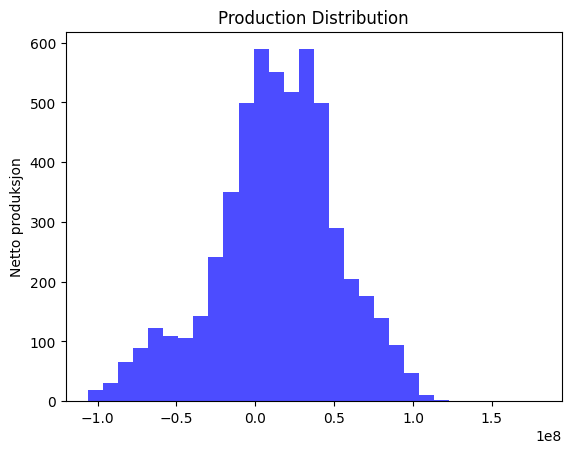

In [117]:
plt.hist(Y, bins=30, color='blue', alpha=0.7)
plt.title('Production Distribution')
plt.xlabel('')
plt.ylabel('Netto produksjon')
plt.show()

In [118]:
energi_data

,Unnamed: 0,DATE,PRISOMRÅDE,FORBRUK_KWH,ANTALL_MÅLEPUNKT,PRODUKSJON_KWH,NETTO_PRODUKSJON_KWH
0,0,2020-12-31,NO1,4.431074e+06,1280088.0,6.590307e+07,6.147199e+07
1,1,2020-12-31,NO2,4.364138e+06,792478.0,1.843103e+08,1.799462e+08
2,2,2020-12-31,NO3,3.112774e+06,518723.0,7.663197e+07,7.351919e+07
3,3,2020-12-31,NO4,1.997586e+06,330240.0,9.987718e+07,9.787959e+07
4,4,2020-12-31,NO5,2.040974e+06,320541.0,1.120536e+08,1.100126e+08
...,...,...,...,...,...,...,...
5475,5475,2023-12-31,NO1,1.148390e+08,30595727.0,3.292689e+07,-8.191216e+07
5476,5476,2023-12-31,NO2,1.038580e+08,18874214.0,1.002392e+08,-3.618725e+06
5477,5477,2023-12-31,NO3,8.617064e+07,12320502.0,6.385201e+07,-2.231863e+07
5478,5478,2023-12-31,NO4,5.950658e+07,7775219.0,8.590868e+07,2.640210e+07


In [119]:
np.any(np.isnan(X))


False

In [120]:
X.dtype

dtype('float64')

In [121]:
X.shape


(5480, 3)

In [122]:
min(Y)


-105899650.812

In [123]:
# normalize data based on mean and standard deviation of the training data
#normalizer = StandardScaler()

#X_train_norm = normalizer.fit_transform(X_train)
#X_val_norm = normalizer.transform(X_val)
#X_test_norm = normalizer.transform(X_test)

In [126]:

# Create temporary DataFrame from the array (Assuming you know the column names)
column_names = ['NETTO_PRODUKSJON_KWH', 'PRODUKSJON_KWH', 'FORBRUK_KWH']  # list all column names
X_train_df = pd.DataFrame(X_train, columns=column_names)

# Now use select_dtypes
numeric_cols = X_train_df.select_dtypes(include=[np.number]).columns


# Convert the selected columns back to NumPy array for scaling
X_train_numeric = X_train_df[numeric_cols].to_numpy()

# Apply scaling
normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train_numeric)

# Repeat the process for X_val and X_test
X_val_df = pd.DataFrame(X_val, columns=column_names)
X_val_numeric = X_val_df[numeric_cols].to_numpy()
X_val_norm = normalizer.transform(X_val_numeric)

X_test_df = pd.DataFrame(X_test, columns=column_names)
X_test_numeric = X_test_df[numeric_cols].to_numpy()
X_test_norm = normalizer.transform(X_test_numeric)



In [128]:
# Assuming X_train, X_val, and X_test are similar to this DataFrame structure

# Identify numeric columns for scaling (excluding 'Unnamed: 0' and non-numeric columns)
#numeric_cols = X_train.select_dtypes(include=[np.number]).columns
#numeric_cols = numeric_cols.drop(['Unnamed: 0'])  # Drop 'Unnamed: 0' if it's just an index

In [129]:

# Apply StandardScaler only to these numeric columns
#normalizer = StandardScaler()
#X_train_norm = X_train.copy()
#X_train_norm[numeric_cols] = normalizer.fit_transform(X_train[numeric_cols])

#X_val_norm = X_val.copy()
#X_val_norm[numeric_cols] = normalizer.transform(X_val[numeric_cols])

#X_test_norm = X_test.copy()
#X_test_norm[numeric_cols] = normalizer.transform(X_test[numeric_cols])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [130]:
# run model selection with tuning data
#model = model_selection(x_train=tune_X_train, y_train=tune_Y_train, x_val=tune_X_val, y_val=tune_Y_val, models=models, parameters=parameters)
selected_model = model_selection(X_train=X_train_norm, Y_train=Y_train, X_val=X_val_norm, Y_val=Y_val, models=models, parameters=parameters)

Model 1 with tuning time: 0:00:37.449638:
Best tuning performance: -445517.2747256121 
Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
Training performance: 225055.520
Validation performance: 33031088.643

Model 2 with tuning time: 0:00:06.013926:
Best tuning performance: -260515.61787398843 
Parameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 1.0}
Training performance: 206021.856
Validation performance: 33148109.154

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 4384, number of used features: 3
[LightGBM] [Info] Start training from score 13089060.754276
Model 3 with tuning time: 0:00:12.640392:
Best tuning performan

In [131]:
# run model_evaluation with test data
selected_model, Y_pred = model_evaluation(model=selected_model, X_test=X_test_norm, Y_test=Y_test)

Test performance: 34717822.025


In [133]:
feature_names = ['PRODUKSJON_KWH','FORBRUK_KWH','NETTO_PRODUKSJON_KWH']

len(feature_names)

3

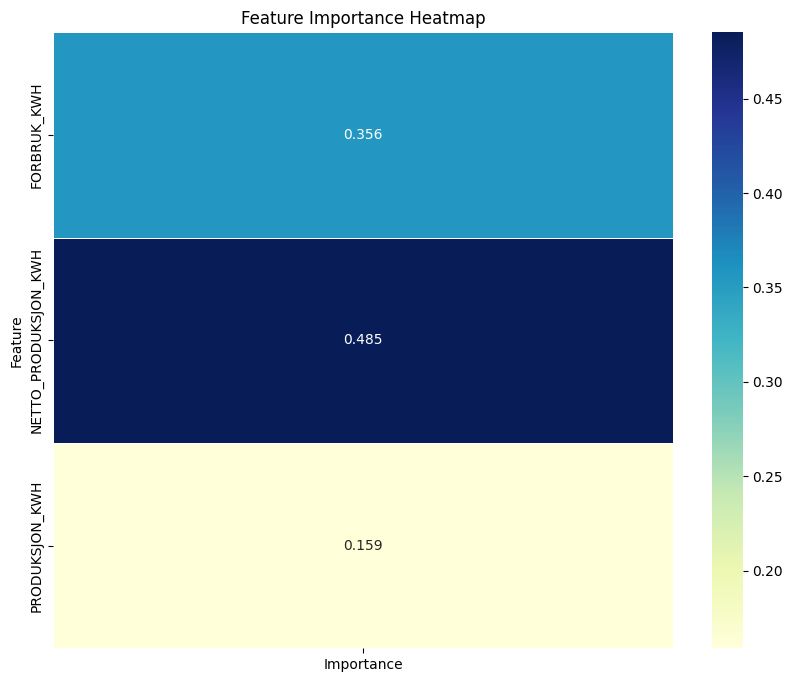

In [134]:
# show feature importance stuff here
feature_importances = selected_model.feature_importances_


df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

heatmap_data = df_importance.pivot_table(index='Feature', values='Importance', aggfunc='mean')

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".3f", linewidths=.5)
plt.title('Feature Importance Heatmap')
plt.show()

In [135]:
print(len(Y_pred))

548


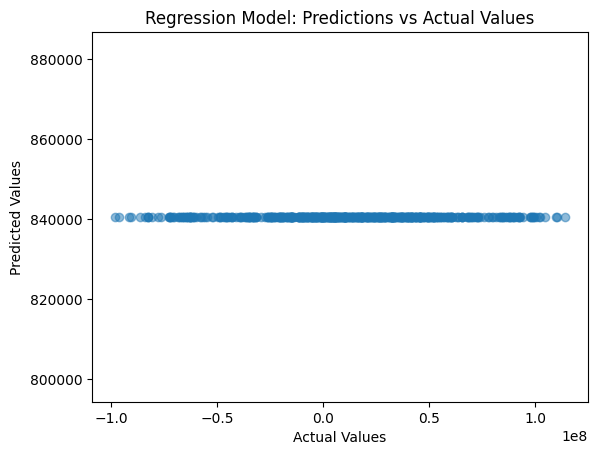

In [136]:

plt.scatter(Y_test, Y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Regression Model: Predictions vs Actual Values")
plt.show()

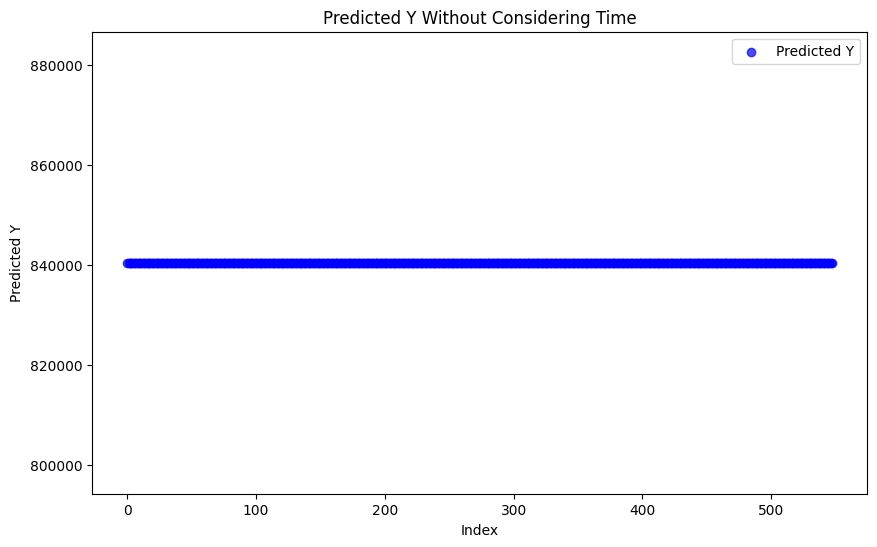

In [137]:
index_values = np.arange(len(Y_pred))
plt.figure(figsize=(10, 6))
plt.scatter(index_values, Y_pred, label='Predicted Y', marker='o', color='blue', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Predicted Y')
plt.title('Predicted Y Without Considering Time')
plt.legend()
plt.show()

In [138]:
import statsmodels.api as sm

df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred})

# Add a constant term for the intercept
X = sm.add_constant(X_test)

# Fit the regression model
model = sm.OLS(Y_train, sm.add_constant(X_train))
results = model.fit()

# Display the regression summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.415e+33
Date:                Fri, 26 Jan 2024   Prob (F-statistic):               0.00
Time:                        13:52:12   Log-Likelihood:                 71821.
No. Observations:                4384   AIC:                        -1.436e+05
Df Residuals:                    4381   BIC:                        -1.436e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.015e-08   8.99e-10     33.525      0.0